In [350]:
import pandas as pd
import numpy as np

# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import matplotlib.image as mpimg

# Préparation des données
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

# Modèles
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
import time

# Option d'affchage
pd.set_option('display.max_columns', None)

In [351]:
t0 = time.time()

In [352]:
df0 = pd.read_csv('/Users/lilian/Desktop/hackathon2021/data/train.csv')

/Users/lilian/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning:

Columns (13,32) have mixed types.Specify dtype option on import or set low_memory=False.



In [353]:
df = df0.copy()

In [354]:
df = df[df['store_id'].isin(list(df['store_id'].sample(600)))].copy()

In [355]:
df.shape

(224202, 34)

In [356]:
df.sample()

,date,store_id,parent_chain_id,store_country,country_iso_code,region_id,store_region,store_segment,store_activity_name,items_first_enabled_date,store_first_saving_date,store_last_saving_date,item_id,item_name,before_price,currency_code,pickup_start,pickup_end,total_supply,declared_supply,manual_added_supply,manual_removed_supply,meals_saved,consumer_cancellation,store_cancellation,item_price,meals_refunded,rating_count,sum_rating_overall,item_view,no_unique_consumers,is_enabled,Département,target
669960,2019-05-02,27257,NaN,France,FR,FR10,Ile-De-France,Bakery,Unknown,2017-07-27,2017-12-04,2021-03-15,27420,NaN,10.0,EUR,2019-05-02 18:00:00.000000,2019-05-02 19:00:00.000000,10,10,0,0,10,0,0,3.0,0,3,14,0,7,True,75,0.0


### Construction de variables intéressantes à partir des préexistantes

In [357]:
# Note moyenne

def compute_note(overall, count):
    try:
        overall / count
    except:
        return np.nan

df['note_moyenne'] = df.apply(lambda row : compute_note(row.sum_rating_overall, row.rating_count) , axis = 1)

In [358]:
# Lifetime

col_date = ['date', 'items_first_enabled_date', 'store_last_saving_date', 'store_first_saving_date',\
            'pickup_start', 'pickup_end']
for col in col_date :
    df[col]= pd.to_datetime(df[col])

df['lifetime'] = df['store_last_saving_date'] - df['store_first_saving_date']



In [359]:
# Reduction

df['reduction'] = 1 - df['item_price'] / df['before_price']

In [360]:
# Temps d'ouverture

df['temps_ouverture'] = df['pickup_end'] - df['pickup_start']

In [361]:
# Heure de début d'ouverture

df['heure_debut_ouverture'] = df.apply(lambda row : row.pickup_start.hour, axis = 1)


In [362]:
# Efficacité

df['efficacite'] = df['meals_saved'] / df['total_supply']

In [363]:
# Franchise

df['franchise'] = df.apply(lambda row : int(row.parent_chain_id > 0), axis = 1)

### Création de nouvelles variables

## Recodage de la variable objectif

In [364]:
def determine_absence_future(date, store_id):
    df_short = df[df['store_id'] == store_id]
    df_short = df_short[df_short['date'] > date]
    
    serie = list(df_short['total_supply'])
    
    i = 0
    l = len(serie)
    try:
        while serie[i] == 0 and i < l:
            i+=1
    except:
        return 0
    
    return i
    

In [365]:
df['absence_future'] = df.apply(lambda row : determine_absence_future(row.date, row.store_id), axis = 1)

In [366]:
# Variance du nombre de vente pour un shop

def compute_variance(date, store_id, variable):
    
    df_short = df[df['store_id'] == store_id]
    df_short = df_short[df_short['date'] < date]
    
    
    
    return df_short[variable].var()

df['variance_ventes'] = df.apply(lambda row : compute_variance(row.date, row.store_id, 'meals_saved'), axis = 1)

In [367]:
# Baisse du nombre de vente dans le mois précedent

def compute_baisse_vente(date, store_id, variable):
    df_short = df[df['store_id'] == store_id]
    df_short = df_short[df_short['date'] < date]
    serie = df_short[variable]
    
    try:
        b = int(np.mean(serie[-30:]) / np.mean(serie[:-30]) < 1)
        
    except:
        b = 0
        
    return b

df['baisse_ventes'] = df.apply(lambda row : compute_baisse_vente(row.date, row.store_id, 'meals_saved'), axis = 1)

In [368]:
# Augmentation de la réduction durant la semaine précedente


def compute_hausse_reduction(date, store_id, variable):
    df_short = df[df['store_id'] == store_id]
    df_short = df_short[df_short['date'] < date]
    serie = df_short[variable]
    
    try:
        b = int(np.mean(serie[-7:]) / np.mean(serie[:-7]) > 1)
        if b:
            print(ok)
        
    except:
        
        b = 0
        
    return b

df['hausse_reduction'] = df.apply(lambda row : compute_hausse_reduction(row.date, row.store_id, 'reduction'), axis = 1)


In [369]:
# Variance de la durée d'ouverture

def compute_variance(date, store_id, variable):
    
    df_short = df[df['store_id'] == store_id]
    #print(df_short.shape)
    df_short = df_short[df_short['date'] < date]
    display(df_short)
    serie = df_short[variable]
    #print(serie)
    variance = np.var([(i.seconds / 3600) for i in serie])
    
    return variance

#df['variance_duree_ouverture'] = df.apply(lambda row : compute_variance(row.date, row.store_id, 'temps_ouverture'), axis = 1)


In [370]:
# Baisse de la note moyenne durant la semaine précedente

def compute_baisse_note(date, store_id, variable):
    df_short = df[df['store_id'] == store_id]
    df_short = df_short[df_short['date'] < date]
    serie = df_short[variable]
    
    try:
        b = np.mean(serie[-7:]) / np.mean(serie[:-7]) < 1
        
    except:
        
        b = 0
        
    return b

df['baisse_note'] = df.apply(lambda row : compute_baisse_note(row.date, row.store_id, 'note_moyenne'), axis = 1)


In [371]:
# Augmentation du nombre d'invendus durant le mois précédent

def compute_hausse_invendus(date, store_id, variable):
    df_short = df[df['store_id'] == store_id]
    df_short = df_short[df_short['date'] < date]
    serie = df_short[variable]
    
    try:
        b = np.mean(serie[-30:]) / np.mean(serie[:-30]) > 1
        
    except:
        b = 0
        
    return b

df['hausse_reduction'] = df.apply(lambda row : compute_hausse_reduction(row.date, row.store_id, 'reduction'), axis = 1)

### Suppression des variables non intéressantes

In [372]:
df.columns

Index(['date', 'store_id', 'parent_chain_id', 'store_country',
       'country_iso_code', 'region_id', 'store_region', 'store_segment',
       'store_activity_name', 'items_first_enabled_date',
       'store_first_saving_date', 'store_last_saving_date', 'item_id',
       'item_name', 'before_price', 'currency_code', 'pickup_start',
       'pickup_end', 'total_supply', 'declared_supply', 'manual_added_supply',
       'manual_removed_supply', 'meals_saved', 'consumer_cancellation',
       'store_cancellation', 'item_price', 'meals_refunded', 'rating_count',
       'sum_rating_overall', 'item_view', 'no_unique_consumers', 'is_enabled',
       'Département', 'target', 'note_moyenne', 'lifetime', 'reduction',
       'temps_ouverture', 'heure_debut_ouverture', 'efficacite', 'franchise',
       'absence_future', 'variance_ventes', 'baisse_ventes',
       'hausse_reduction', 'baisse_note'],
      dtype='object')

In [373]:
df = df.drop(columns = ['parent_chain_id', 'store_country', 'country_iso_code', 'region_id', 'store_activity_name', 'item_id', 'item_name', 'currency_code',
                       'pickup_end', 'pickup_start', 'declared_supply', 'manual_removed_supply', 'store_cancellation', 'item_price',
                       'meals_refunded', 'rating_count', 'sum_rating_overall', 'item_view', 'no_unique_consumers', 'is_enabled', 'Département', 'store_id', 'target'])
df.sample(10)

,date,store_region,store_segment,items_first_enabled_date,store_first_saving_date,store_last_saving_date,before_price,total_supply,manual_added_supply,meals_saved,consumer_cancellation,note_moyenne,lifetime,reduction,temps_ouverture,heure_debut_ouverture,efficacite,franchise,absence_future,variance_ventes,baisse_ventes,hausse_reduction,baisse_note
4289694,2019-06-19,Nord-Pas De Calais,Bakery,2019-05-27,2019-05-27,2021-03-15,12.0,8,3,8,3,NaN,658 days,0.667500,0 days 00:15:00,17.0,1.0,1,0,6.173846,0,0,False
3074983,2019-05-29,Midi-Pyrénées,Bakery,2019-01-10,2019-01-10,2021-03-15,12.0,3,3,3,0,NaN,795 days,0.667500,0 days 00:30:00,16.0,1.0,1,3,4.978898,0,0,False
2030406,2019-07-14,Lorraine,Fruits & vegetables store,2018-07-03,2018-07-03,2020-03-09,10.0,0,0,0,0,NaN,615 days,0.701000,0 days 00:00:00,22.0,NaN,0,0,4.854896,0,0,False
4929234,2020-01-13,Pays De La Loire,Traditional Restaurant,2019-10-02,2019-10-02,2020-02-15,12.0,0,0,0,0,NaN,136 days,0.667500,NaT,NaN,NaN,0,3,1.114792,1,0,False
820166,2020-04-04,Ile-De-France,Fast Food / Take away restaurant,2017-11-09,2017-12-02,2020-12-18,10.0,0,0,0,0,NaN,1112 days,0.710000,NaT,NaN,NaN,0,0,0.305230,0,0,False
643723,2019-12-24,Bretagne,Bakery,2017-07-11,2017-12-02,2020-11-30,10.0,0,0,0,0,NaN,1094 days,0.600000,NaT,NaN,NaN,1,1,0.109212,0,0,False
5029160,2019-10-18,Champagne-Ardenne,Hotel,2019-10-18,2019-10-21,2020-03-12,NaN,0,0,0,0,NaN,143 days,NaN,NaT,NaN,NaN,1,0,NaN,0,0,False
1878413,2019-04-24,Alsace,Bakery,2018-06-06,2018-06-06,2018-10-05,10.0,0,0,0,0,NaN,121 days,0.701000,0 days 00:55:00,16.0,NaN,0,0,0.000000,0,0,False
1327612,2019-09-23,Centre - Val De Loire,Bakery,2018-02-21,2018-02-21,2021-03-15,12.0,8,0,8,0,NaN,1118 days,0.666667,0 days 00:15:00,17.0,1.0,1,0,7.394568,0,0,False
398308,2019-02-15,Ile-De-France,Bakery,2017-04-03,2017-12-02,2021-03-15,14.0,1,0,1,0,NaN,1199 days,0.678571,0 days 00:30:00,18.0,1.0,1,0,1.572727,0,0,False


In [374]:
print((time.time() - t0)/ 60)

65.02325536410014


### Mise en forme des données

In [375]:
categ_var = ['store_region', 'store_segment']
for var in categ_var:
    df = pd.concat([df, pd.get_dummies(df[var], prefix = var)], axis = 1).drop(columns = [var])


In [376]:
df['lifetime'] = df['lifetime'].dt.days

In [377]:
m = min(df['items_first_enabled_date'])

date_m = df['date'] - m
items_first_enabled_date_m = df['items_first_enabled_date']-m
store_first_saving_date_m = df['store_first_saving_date']-m
store_last_saving_date_m = df['store_last_saving_date']-m

df.drop(columns = ['date'])
df.drop(columns = ['items_first_enabled_date'])
df.drop(columns = ['store_first_saving_date'])
df.drop(columns = ['store_last_saving_date'])

df['date'] = date_m.apply(lambda x: x.days)
df['items_first_enabled_date'] = items_first_enabled_date_m.apply(lambda x: x.days)
df['store_first_saving_date'] = store_first_saving_date_m.apply(lambda x: x.days)
df['store_last_saving_date'] = store_last_saving_date_m.apply(lambda x: x.days)


df['temps_ouverture'] = df['temps_ouverture'].apply(lambda x: x.seconds/3600)

In [378]:
df

,date,items_first_enabled_date,store_first_saving_date,store_last_saving_date,before_price,total_supply,manual_added_supply,meals_saved,consumer_cancellation,note_moyenne,lifetime,reduction,temps_ouverture,heure_debut_ouverture,efficacite,franchise,absence_future,variance_ventes,baisse_ventes,hausse_reduction,baisse_note,store_region_Alsace,store_region_Aquitaine,store_region_Auvergne,store_region_Basse-Normandie,store_region_Bourgogne,store_region_Bretagne,store_region_Centre - Val De Loire,store_region_Champagne-Ardenne,store_region_Franche-Comté,store_region_Haute-Normandie,store_region_Ile-De-France,store_region_Languedoc-Roussillon,store_region_Limousin,store_region_Lorraine,store_region_Midi-Pyrénées,store_region_Nord-Pas De Calais,store_region_Pays De La Loire,store_region_Picardie,store_region_Poitou-Charentes,store_region_Provence-Alpes-Côte D’Azur,store_region_Rhône-Alpes,store_segment_Bakery,store_segment_Beverages,store_segment_Buffet,store_segment_Butcher,store_segment_Canteen,store_segment_Caterer,store_segment_Fast Food / Take away restaurant,store_segment_Florist,store_segment_Fruits & vegetables store,store_segment_Hotel,store_segment_Manufacturer,store_segment_Market stall,store_segment_Other,store_segment_Other Specialists,store_segment_Pastry,store_segment_Supermarket Big,store_segment_Supermarket Medium,store_segment_Supermarket Small,store_segment_Sushi,store_segment_Traditional Restaurant
847,1105,1105.0,1105.0,1217.0,48.0,1,1,1,0,NaN,112.0,0.666667,0.25,17.0,1.0,0,14,NaN,0,0,False,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
848,1105,1105.0,1105.0,1217.0,36.0,2,2,2,0,NaN,112.0,0.666667,0.25,17.0,1.0,0,14,NaN,0,0,False,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
849,1106,1105.0,1105.0,1217.0,36.0,0,0,0,0,NaN,112.0,0.666667,NaN,NaN,NaN,0,12,0.500000,0,0,False,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
850,1106,1105.0,1105.0,1217.0,48.0,0,0,0,0,NaN,112.0,0.666667,NaN,NaN,NaN,0,12,0.500000,0,0,False,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
851,1107,1105.0,1105.0,1217.0,36.0,0,0,0,0,NaN,112.0,0.666667,NaN,NaN,NaN,0,10,0.916667,0,0,False,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5420791,1420,1381.0,1384.0,1743.0,12.0,0,0,0,0,NaN,359.0,0.667500,NaN,NaN,NaN,1,0,9.851552,1,0,False,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
5420792,1421,1381.0,1384.0,1743.0,12.0,0,0,0,0,NaN,359.0,0.667500,NaN,NaN,NaN,1,0,9.720513,1,0,False,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
5420793,1422,1381.0,1384.0,1743.0,12.0,0,0,0,0,NaN,359.0,0.667500,NaN,NaN,NaN,1,0,9.590244,1,0,False,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
5420794,1423,1381.0,1384.0,1743.0,12.0,0,0,0,0,NaN,359.0,0.667500,NaN,NaN,NaN,1,0,9.461092,1,0,False,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [379]:
df = df.drop(columns = ['before_price', 'note_moyenne', 'reduction', 'efficacite'])

In [380]:
df = df.dropna()

In [381]:
min_max_scaler = preprocessing.MinMaxScaler()

df[list(df.columns)] = min_max_scaler.fit_transform(df[list(df.columns)])

In [382]:
df

,date,items_first_enabled_date,store_first_saving_date,store_last_saving_date,total_supply,manual_added_supply,meals_saved,consumer_cancellation,lifetime,temps_ouverture,heure_debut_ouverture,franchise,absence_future,variance_ventes,baisse_ventes,hausse_reduction,baisse_note,store_region_Alsace,store_region_Aquitaine,store_region_Auvergne,store_region_Basse-Normandie,store_region_Bourgogne,store_region_Bretagne,store_region_Centre - Val De Loire,store_region_Champagne-Ardenne,store_region_Franche-Comté,store_region_Haute-Normandie,store_region_Ile-De-France,store_region_Languedoc-Roussillon,store_region_Limousin,store_region_Lorraine,store_region_Midi-Pyrénées,store_region_Nord-Pas De Calais,store_region_Pays De La Loire,store_region_Picardie,store_region_Poitou-Charentes,store_region_Provence-Alpes-Côte D’Azur,store_region_Rhône-Alpes,store_segment_Bakery,store_segment_Beverages,store_segment_Buffet,store_segment_Butcher,store_segment_Canteen,store_segment_Caterer,store_segment_Fast Food / Take away restaurant,store_segment_Florist,store_segment_Fruits & vegetables store,store_segment_Hotel,store_segment_Manufacturer,store_segment_Market stall,store_segment_Other,store_segment_Other Specialists,store_segment_Pastry,store_segment_Supermarket Big,store_segment_Supermarket Medium,store_segment_Supermarket Small,store_segment_Sushi,store_segment_Traditional Restaurant
863,0.357438,0.800145,0.644087,0.559095,0.108434,0.019608,0.030769,0.0,0.093411,0.043732,0.739130,0.0,0.025172,0.000543,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
876,0.369835,0.800145,0.644087,0.559095,0.096386,0.009804,0.015385,0.0,0.093411,0.010933,0.739130,0.0,0.027460,0.000551,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
889,0.384298,0.800145,0.644087,0.559095,0.108434,0.019608,0.030769,0.0,0.093411,0.010933,0.739130,0.0,0.000000,0.000410,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
890,0.384298,0.800145,0.644087,0.559095,0.096386,0.009804,0.015385,0.0,0.093411,0.010933,0.739130,0.0,0.000000,0.000410,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
891,0.386364,0.800145,0.644087,0.559095,0.096386,0.009804,0.015385,0.0,0.093411,0.010933,0.695652,0.0,0.025172,0.000562,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5420774,0.956612,1.000000,0.964409,1.000000,0.132530,0.039216,0.061538,0.0,0.299416,0.087464,0.608696,1.0,0.013730,0.023422,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5420781,0.971074,1.000000,0.964409,1.000000,0.156627,0.058824,0.092308,0.0,0.299416,0.142128,0.521739,1.0,0.002288,0.020677,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5420783,0.975207,1.000000,0.964409,1.000000,0.144578,0.049020,0.076923,0.0,0.299416,0.065598,0.608696,1.0,0.004577,0.020431,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,

In [383]:
df.to_csv('df_calculee')

## Application des modeles

In [384]:
# On définit les échantillons

y = df[['absence_future']]
X = df.drop(columns = ['absence_future'])

# On choisit un échantillon de validation de 20 %

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2)

In [385]:
N = X.shape[1]

## Regression linéaire

In [386]:
lin_reg = LinearRegression().fit(X_train, y_train)

# On prédit à partir de l'échantillon de test pour calculer les scores

y_pred = lin_reg.predict(X_test)

In [387]:
px.histogram(pd.DataFrame([
    (X.columns[i], lin_reg.coef_[0][i]) for i in range(N)
                    ]).T.rename(index = {0 : 'variable', 1 : 'coeff'}).T, x = 'variable', y = 'coeff', histfunc = 'sum'
            ).show()

print('MSE :', mean_squared_error(y_test, y_pred))

MSE : 0.001595297435036699


In [388]:
# Affichage des p-values

mod = sm.OLS(y,X)
fii = mod.fit()
p_values = fii.summary2().tables[1]['P>|t|']
pd.DataFrame(p_values).T

,date,items_first_enabled_date,store_first_saving_date,store_last_saving_date,total_supply,manual_added_supply,meals_saved,consumer_cancellation,lifetime,temps_ouverture,heure_debut_ouverture,franchise,variance_ventes,baisse_ventes,hausse_reduction,baisse_note,store_region_Alsace,store_region_Aquitaine,store_region_Auvergne,store_region_Basse-Normandie,store_region_Bourgogne,store_region_Bretagne,store_region_Centre - Val De Loire,store_region_Champagne-Ardenne,store_region_Franche-Comté,store_region_Haute-Normandie,store_region_Ile-De-France,store_region_Languedoc-Roussillon,store_region_Limousin,store_region_Lorraine,store_region_Midi-Pyrénées,store_region_Nord-Pas De Calais,store_region_Pays De La Loire,store_region_Picardie,store_region_Poitou-Charentes,store_region_Provence-Alpes-Côte D’Azur,store_region_Rhône-Alpes,store_segment_Bakery,store_segment_Beverages,store_segment_Buffet,store_segment_Butcher,store_segment_Canteen,store_segment_Caterer,store_segment_Fast Food / Take away restaurant,store_segment_Florist,store_segment_Fruits & vegetables store,store_segment_Hotel,store_segment_Manufacturer,store_segment_Market stall,store_segment_Other,store_segment_Other Specialists,store_segment_Pastry,store_segment_Supermarket Big,store_segment_Supermarket Medium,store_segment_Supermarket Small,store_segment_Sushi,store_segment_Traditional Restaurant
P>|t|,0.0,0.0,7.334400e-108,4.724676e-105,1.412702e-56,4.605169e-49,1.267675e-08,0.198262,6.788220e-105,6.332252e-08,1.778032e-09,4.216141e-49,4.131521e-74,1.105595e-34,1.447598e-105,1.489897e-105,0.425282,0.578951,0.211924,0.227383,0.38037,6.287512e-09,0.526003,0.016504,0.05799,0.045707,0.001141,0.386354,0.000005,0.616208,0.355285,0.854875,0.419568,0.449477,0.77242,0.783519,0.129155,0.001485,0.034469,0.006802,0.000023,0.953805,1.050320e-10,0.688566,0.050121,0.368366,0.438506,0.00812,0.425643,0.049029,0.0,0.000001,1.202827e-41,1.036191e-12,0.815888,1.990964e-14,0.03303


In [389]:
EN_reg = ElasticNet(alpha=.1, copy_X=True, fit_intercept = False, l1_ratio=.031)

EN_reg.fit(X_train, y_train)

ElasticNet(alpha=0.1, fit_intercept=False, l1_ratio=0.031)

In [390]:
y_pred = EN_reg.predict(X_test)
print('MSE : ', mean_squared_error(y_test, y_pred))

MSE :  0.0018579229322658658


In [391]:
pd.DataFrame([(X.columns[i], EN_reg.coef_[i]) for i in range(N)]).T.rename(index = {0 : 'variable', 1 : 'coeff'})

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56
variable,date,items_first_enabled_date,store_first_saving_date,store_last_saving_date,total_supply,manual_added_supply,meals_saved,consumer_cancellation,lifetime,temps_ouverture,heure_debut_ouverture,franchise,variance_ventes,baisse_ventes,hausse_reduction,baisse_note,store_region_Alsace,store_region_Aquitaine,store_region_Auvergne,store_region_Basse-Normandie,store_region_Bourgogne,store_region_Bretagne,store_region_Centre - Val De Loire,store_region_Champagne-Ardenne,store_region_Franche-Comté,store_region_Haute-Normandie,store_region_Ile-De-France,store_region_Languedoc-Roussillon,store_region_Limousin,store_region_Lorraine,store_region_Midi-Pyrénées,store_region_Nord-Pas De Calais,store_region_Pays De La Loire,store_region_Picardie,store_region_Poitou-Charentes,store_region_Provence-Alpes-Côte D’Azur,store_region_Rhône-Alpes,store_segment_Bakery,store_segment_Beverages,store_segment_Buffet,store_segment_Butcher,store_segment_Canteen,store_segment_Caterer,store_segment_Fast Food / Take away restaurant,store_segment_Florist,store_segment_Fruits & vegetables store,store_segment_Hotel,store_segment_Manufacturer,store_segment_Market stall,store_segment_Other,store_segment_Other Specialists,store_segment_Pastry,store_segment_Supermarket Big,store_segment_Supermarket Medium,store_segment_Supermarket Small,store_segment_Sushi,store_segment_Traditional Restaurant
coeff,0,0.000157771,0,0.00222486,0,-0,-0,-0,0,0,0,0.000408209,0,0,0,0,0,0,-0,-0,-0,0,-0,0,-0,-0,0,0,0,-0,-0,0,-0,-0,0,-0,0,-0,-0,0,0,-0,0,0,0,0,0,0,-0,0,0,0,0,0,0,0,0


## RF

In [392]:
# On définit d'abord une fonction qui donne l'importance des variables vis à vis d'un certain modèle

def feat_importance(model, x_train, y_train, X):
    """
    Renvoie le tableau de l'importance des variables vis à vis du modèle par la méthode des permutations
    """

    result = permutation_importance(
                                    model, 
                                    X, 
                                    y, 
                                    n_repeats = 3,
                                    random_state = 0
                                    )['importances_mean']
    
    importance = pd.DataFrame(result, index = X.columns, columns = ["Importance"])
    
    return importance.sort_values(by = ['Importance'], ascending = False)

In [393]:
# Création des essembles de tests et d'entrainement, on choisit une taile de test de 30% ici

X = df.drop(['absence_future'], axis = 1)
x = np.array(X)
y = np.array(df['absence_future'])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 41)
# random_state correspond à la graine générant l'échantillon aléatoire

In [394]:
max_depth_ls = [1, 10, 13, 15, 17, 20, 25, 30] # profondeurs maximales des arbres de décision testées
mse_train_max_depth = []
mse_test_max_depth = []

# Pour chaque profondeur max, on regresse avec random forest

for m in max_depth_ls :
    
    print('Profondeur téstée : ', m)
    
    rf = RandomForestRegressor(
                            max_depth = m, 
                            random_state=0,
                            n_estimators = 30) # nombre d'arbres utilisés
    
    rf = rf.fit(x_train, y_train)
    y_pred_train = rf.predict(x_train)
    y_pred = rf.predict(x_test)
    
    mse_train_max_depth.append(mean_squared_error(y_train, y_pred_train))
    mse_test_max_depth.append(mean_squared_error(y_test, y_pred))

Profondeur téstée :  1
Profondeur téstée :  10
Profondeur téstée :  13
Profondeur téstée :  15
Profondeur téstée :  17
Profondeur téstée :  20
Profondeur téstée :  25
Profondeur téstée :  30


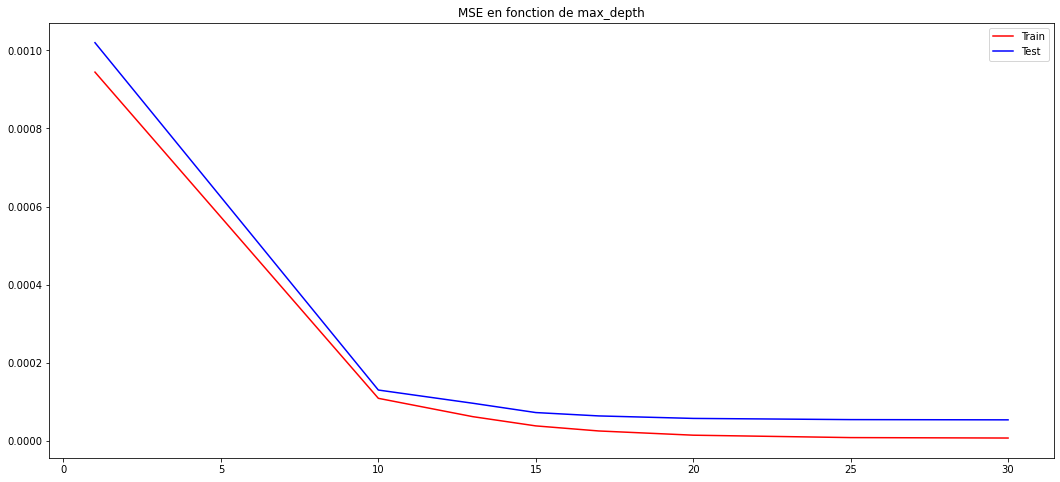

In [395]:
# On affiche ensuite les performances de la regression sur les deux échantillon (train et test)

fig, ax = plt.subplots(figsize = (18, 8))
plt.plot(max_depth_ls, mse_train_max_depth, color = 'red', label = 'Train')
plt.plot(max_depth_ls, mse_test_max_depth, color = 'blue', label = 'Test')
plt.title('MSE en fonction de max_depth')
plt.legend()
plt.show()

In [396]:
#On regarde la valeur qui minimise la MSE sur l'ensemble de test

max_depth_ls[mse_test_max_depth.index(min(mse_test_max_depth))]

30

In [397]:
# On regarde maintenant l'effet du nombre d'arbre sur l'effet de la regression

nb_estimators_ls = [1, 2, 3, 5, 20, 40, 50, 60, 80]
mse_train_nb_estimators = []
mse_test_nb_estimators = []

for m in nb_estimators_ls :
    print("Nombre d'arbres testés : ", m)
    rf = RandomForestRegressor(max_depth = 15, 
                               random_state = 0,
                                n_estimators = m)    
    
    rf = rf.fit(x_train, y_train)
    y_pred_train = rf.predict(x_train)
    y_pred = rf.predict(x_test)
    
    mse_train_nb_estimators.append(mean_squared_error(y_train, y_pred_train))
    mse_test_nb_estimators.append(mean_squared_error(y_test, y_pred))



Nombre d'arbres testés :  1
Nombre d'arbres testés :  2
Nombre d'arbres testés :  3
Nombre d'arbres testés :  5
Nombre d'arbres testés :  20
Nombre d'arbres testés :  40
Nombre d'arbres testés :  50
Nombre d'arbres testés :  60
Nombre d'arbres testés :  80


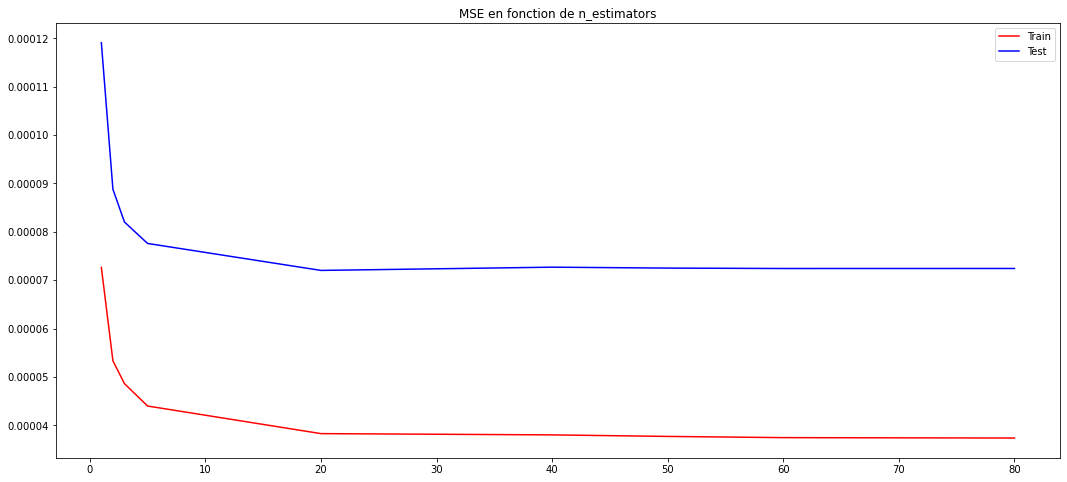

In [398]:
# On affiche ensuite les performances de la regression sur les deux échantillon (train et test)

fig, ax = plt.subplots(figsize = (18, 8))
plt.plot(nb_estimators_ls, mse_train_nb_estimators, color = 'red', label = 'Train')
plt.plot(nb_estimators_ls, mse_test_nb_estimators, color = 'blue', label = 'Test')
plt.title('MSE en fonction de n_estimators')
plt.legend()
plt.show()

In [399]:
# On fait varier le nombre minimum d'exemple requis pour créer une feuille/noeud

samples_leaf_ls = [1, 2, 3, 4, 10]
mse_train_samples_leaf = []
mse_test_samples_leaf = []


for m in samples_leaf_ls :
    print('min_samples_leaf testé : ', m)
    rf = RandomForestRegressor( max_depth = 15, 
                                min_samples_leaf = m,
                                n_estimators = 60, 
                                random_state = 0
                              )    
    
    rf = rf.fit(x_train, y_train)
    y_pred_train = rf.predict(x_train)
    y_pred = rf.predict(x_test)
    
    mse_train_samples_leaf.append(mean_squared_error(y_train, y_pred_train))
    mse_test_samples_leaf.append(mean_squared_error(y_test, y_pred))

min_samples_leaf testé :  1
min_samples_leaf testé :  2
min_samples_leaf testé :  3
min_samples_leaf testé :  4
min_samples_leaf testé :  10


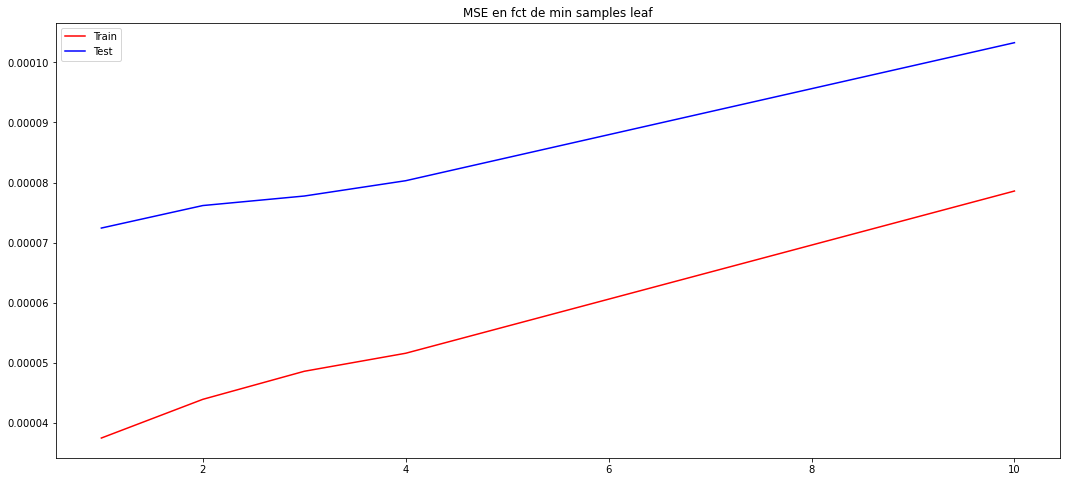

In [400]:
# On affiche ensuite les performances de la regression sur les deux échantillon (train et test)

fig, ax = plt.subplots(figsize = (18, 8))
plt.plot(samples_leaf_ls, mse_train_samples_leaf, color='red', label='Train')
plt.plot(samples_leaf_ls, mse_test_samples_leaf, color='blue', label='Test')
plt.title('MSE en fct de min samples leaf')
plt.legend()
plt.show()

In [401]:
max_leaf_ls = [2, 10, 100, 150, 200, 1000, 1500]
mse_train_max_leaf = []
mse_test_max_leaf = []



for m in max_leaf_ls :
    
    print('Nombre de feuilles max testé : ', m)
    rf = RandomForestRegressor(max_depth = 15, 
                               min_samples_leaf = 1, 
                               max_leaf_nodes = m,
                               n_estimators = 60)   
    
    rf = rf.fit(x_train, y_train)
    y_pred_train = rf.predict(x_train)
    y_pred = rf.predict(x_test)
    mse_train_max_leaf.append(mean_squared_error(y_train, y_pred_train))
    mse_test_max_leaf.append(mean_squared_error(y_test, y_pred))

Nombre de feuilles max testé :  2
Nombre de feuilles max testé :  10
Nombre de feuilles max testé :  100
Nombre de feuilles max testé :  150
Nombre de feuilles max testé :  200
Nombre de feuilles max testé :  1000
Nombre de feuilles max testé :  1500


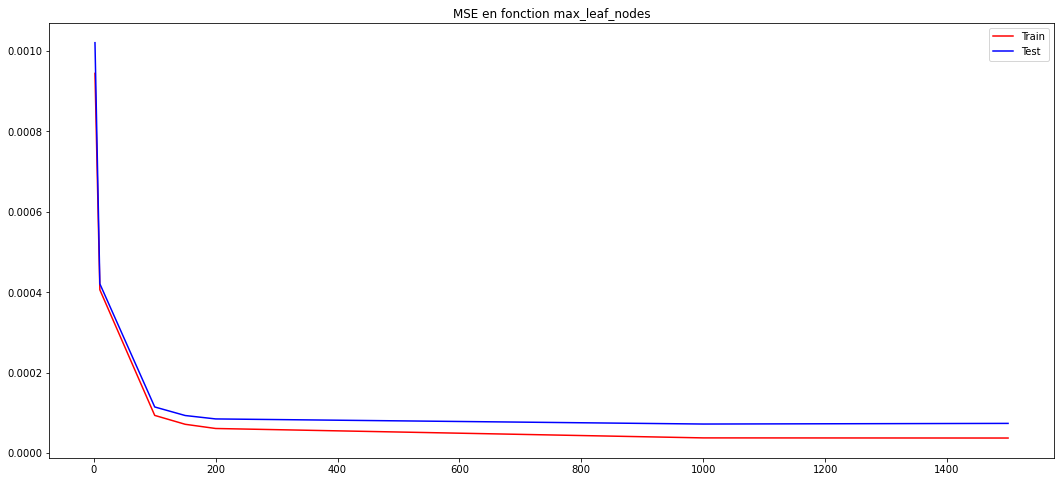

In [402]:
# On affiche ensuite les performances de la regression sur les deux échantillon (train et test)

fig, ax = plt.subplots(figsize = (18, 8))
plt.plot(max_leaf_ls, mse_train_max_leaf, color = 'red', label = 'Train')
plt.plot(max_leaf_ls, mse_test_max_leaf, color = 'blue', label = 'Test')
plt.title('MSE en fonction max_leaf_nodes')
plt.legend()
plt.show()

In [403]:
# On a maintenant tous nos paramètres

rf = RandomForestRegressor(
                        max_depth = 15, 
                        min_samples_leaf = 1, 
                        max_leaf_nodes = 1000,
                        n_estimators = 60
                            )    

rf = rf.fit(x_train, y_train)
y_pred_train = rf.predict(x_train)
y_pred = rf.predict(x_test)
oo = np.zeros(y_pred.shape)

print('MSE train : ', mean_squared_error(y_train, y_pred_train))
print('MSE test : ', mean_squared_error(y_test, y_pred))
print('MSE modèle nulle : ', mean_squared_error(y_test, oo))

importance = feat_importance(rf, x_train, y_train, X)

MSE train :  3.749195747109384e-05
MSE test :  7.261671115007069e-05
MSE modèle nulle :  0.0021486871940774466


In [ ]:
import pickle

Pkl_File = "RF_Model.pkl"  

with open(Pkl_File, 'wb') as file:  
    pickle.dump(rf, file)

In [411]:
rf.save()

AttributeError: 'RandomForestRegressor' object has no attribute 'save'

<AxesSubplot:>

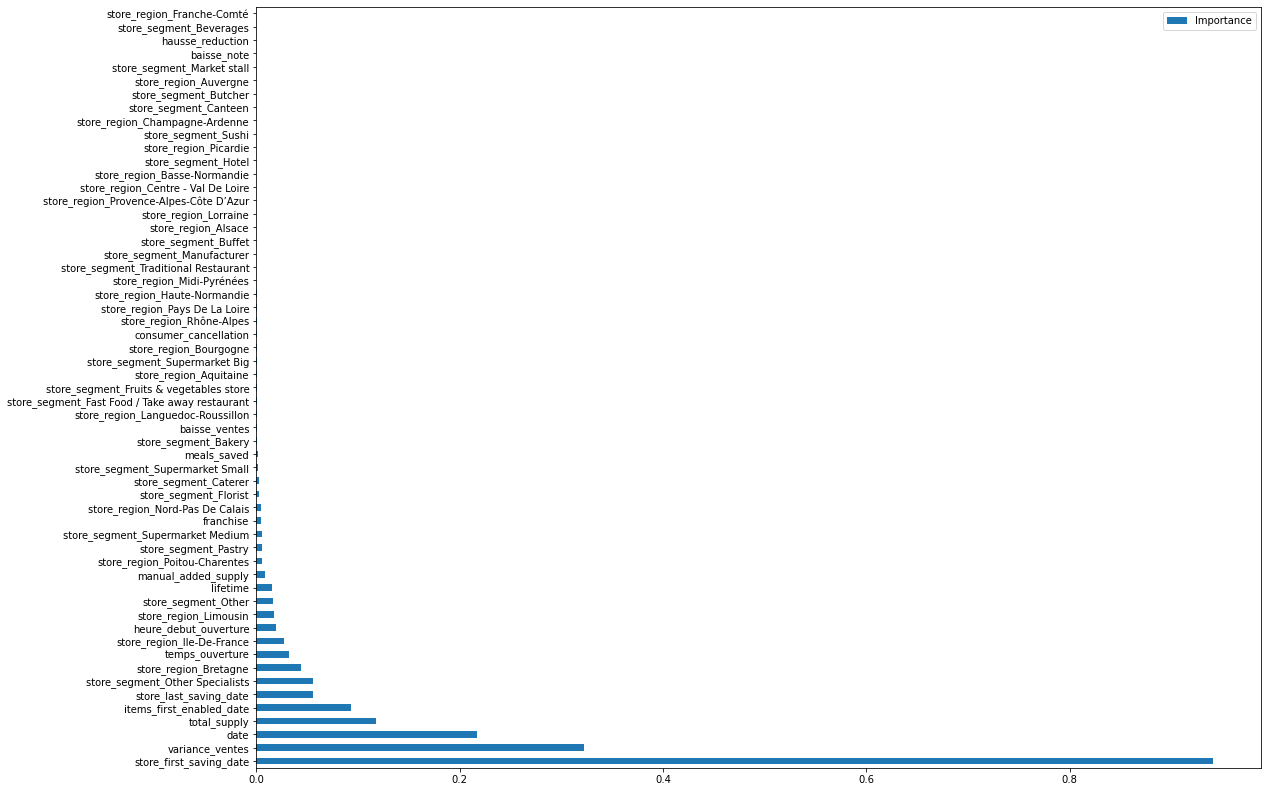

In [404]:
importance.plot(kind = 'barh', figsize = (18, 14))

In [405]:
# On définit les échantillons

y = df[['absence_future']]
X = df.drop(columns = ['absence_future'])

In [406]:
# Construction de l'architecture du réseau

model = Sequential()

model.add(Dense(70, input_dim = N, activation = 'relu'))

model.add(Dense(12))
model.add(Dense(13))
model.add(Dense(15))
model.add(Dense(5))
model.add(Dense(1))

model.compile(optimizer = 'adam', loss = 'mse')

In [407]:
# Lancement de la phase d'apprentissage

history = model.fit(X, y, validation_split = 0.2,  epochs = 30)

Epoch 1/30
3752/3752 [==============================] - 7s 2ms/step - loss: 0.0024 - val_loss: 0.0046
Epoch 2/30
3752/3752 [==============================] - 6s 2ms/step - loss: 3.2751e-04 - val_loss: 0.0052
Epoch 3/30
3752/3752 [==============================] - 6s 2ms/step - loss: 2.3281e-04 - val_loss: 0.0047
Epoch 4/30
3752/3752 [==============================] - 6s 2ms/step - loss: 1.8178e-04 - val_loss: 0.0045
Epoch 5/30
3752/3752 [==============================] - 6s 2ms/step - loss: 1.6528e-04 - val_loss: 0.0045
Epoch 6/30
3752/3752 [==============================] - 6s 2ms/step - loss: 1.5175e-04 - val_loss: 0.0043
Epoch 7/30
3752/3752 [==============================] - 6s 2ms/step - loss: 1.3550e-04 - val_loss: 0.0042
Epoch 8/30
3752/3752 [==============================] - 6s 2ms/step - loss: 1.2642e-04 - val_loss: 0.0046
Epoch 9/30
3752/3752 [==============================] - 6s 2ms/step - loss: 1.2641e-04 - val_loss: 0.0044
Epoch 10/30
3752/3752 [===========================

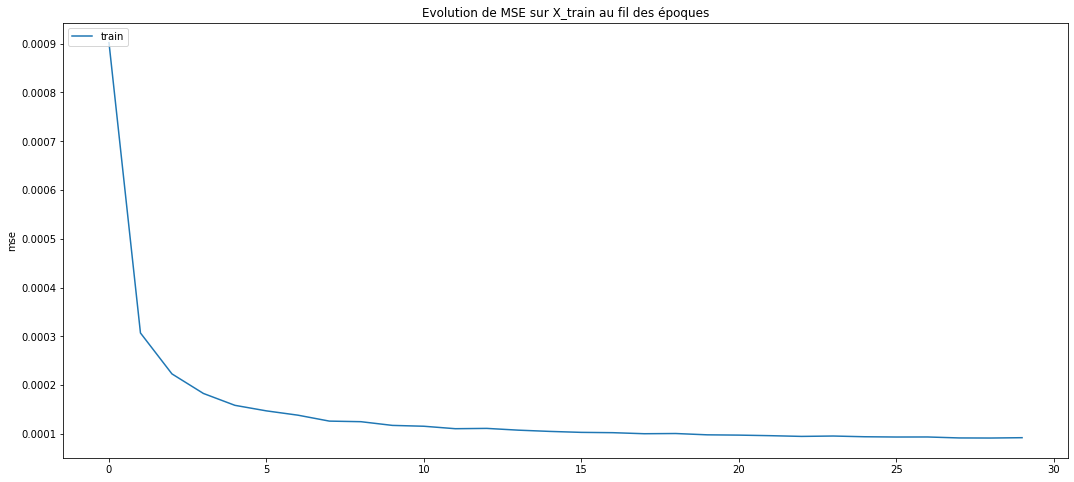

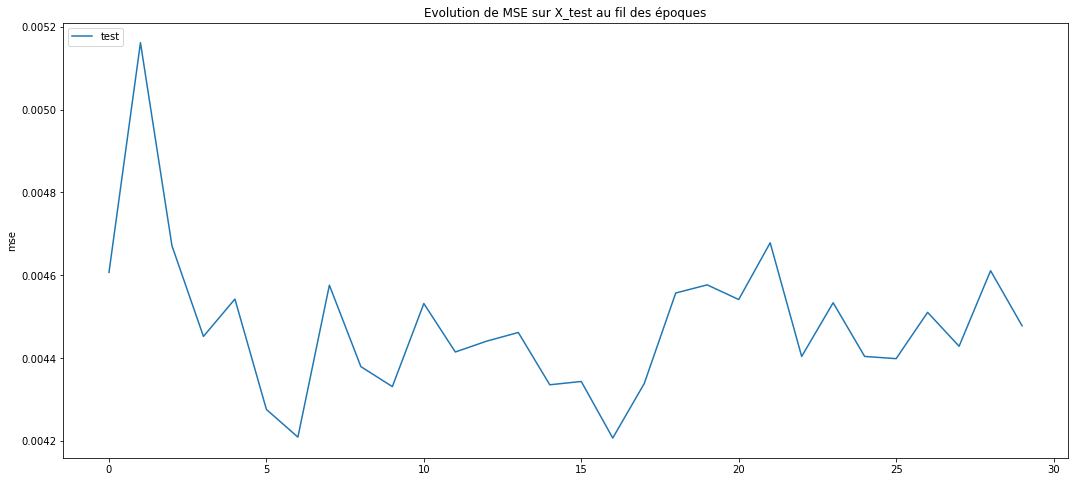

In [408]:
# On affiche l'évolution de la loss au fil des époques pour les échantillons train et test.

fig, ax = plt.subplots(figsize = (18, 8))
plt.plot(history.history['loss'])
plt.title('Evolution de MSE sur X_train au fil des époques')
plt.ylabel('mse')
plt.legend(['train'], loc = 'upper left')
plt.show()

fig, ax = plt.subplots(figsize = (18, 8))
plt.plot(history.history['val_loss'])
plt.title('Evolution de MSE sur X_test au fil des époques')
plt.ylabel('mse')
plt.legend(['test'], loc = 'upper left')
plt.show()

In [409]:
perm = PermutationImportance(model, scoring = 'r2', random_state = 1).fit(X,y)
eli5.show_weights(perm, feature_names = X.columns.tolist(), top = N)

KeyboardInterrupt: 

In [ ]:
print((time.time() - t0)/ 60)